# 📊 Notebook 02: Data Quality Assessment

**Autor:** Gian  
**Fecha:** 2026-01-19  
**Objetivo:** Análisis profundo de calidad de datos del dataset NYC Telecom  

---

## 📋 Contenido

1. Configuración del entorno
2. Carga de datos
3. Análisis de valores nulos
4. Detección de outliers
5. Análisis de distribuciones
6. Análisis de tipos de datos
7. Reporte de calidad
8. Conclusiones

---
## 1. Configuración del Entorno

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from scipy import stats

# Configuración
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

# Seed
np.random.seed(42)

print("✅ Librerías importadas correctamente")

✅ Librerías importadas correctamente


---
## 2. Carga de Datos

In [2]:
# Rutas
DATA_PATH = Path('../../data/data.csv')
OUTPUT_PATH = Path('../../outputs/gian')

# Cargar datos
df = pd.read_csv(DATA_PATH)

print(f"✅ Dataset cargado: {df.shape[0]:,} registros × {df.shape[1]} columnas")
print(f"💾 Memoria: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

✅ Dataset cargado: 9,701 registros × 67 columnas
💾 Memoria: 18.67 MB


---
## 3. Análisis de Valores Nulos

In [3]:
# Análisis detallado de nulos
null_analysis = pd.DataFrame({
    'Columna': df.columns,
    'Nulos': df.isnull().sum(),
    'Porcentaje': (df.isnull().sum() / len(df)) * 100,
    'Tipo': df.dtypes
}).sort_values('Nulos', ascending=False)

# Solo columnas con nulos
null_cols = null_analysis[null_analysis['Nulos'] > 0]

print("🔍 Columnas con valores nulos:")
print()
null_cols

🔍 Columnas con valores nulos:



,Columna,Nulos,Porcentaje,Tipo
respuesta_encuesta,respuesta_encuesta,1455,14.998454,object
referencias_hechas,referencias_hechas,1164,11.998763,float64
edad,edad,776,7.999175,float64
dias_ultima_conexion,dias_ultima_conexion,485,4.999485,float64



✅ Gráfico guardado en: ../../outputs/gian/figures/eda/02_null_values_analysis.png


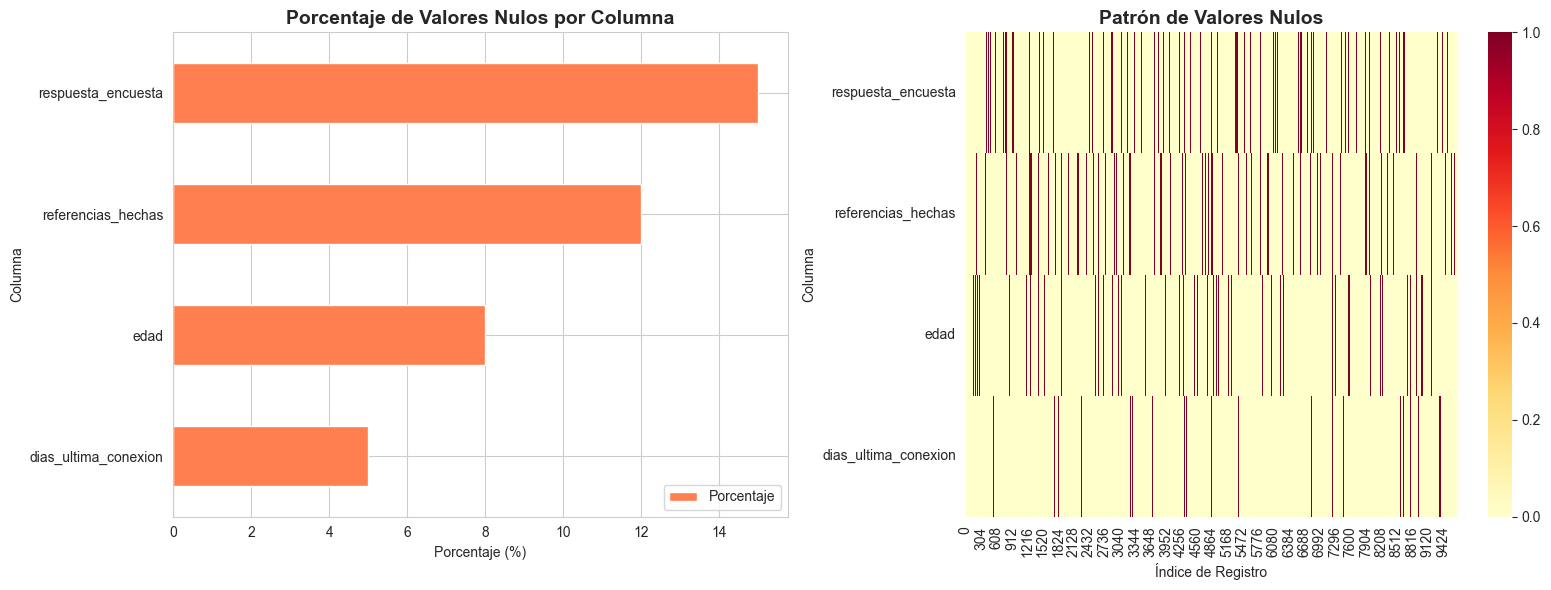

In [4]:
# Visualización de nulos
if len(null_cols) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Gráfico de barras
    null_cols.sort_values('Porcentaje', ascending=True).plot(
        x='Columna', y='Porcentaje', kind='barh', ax=ax1, color='coral'
    )
    ax1.set_title('Porcentaje de Valores Nulos por Columna', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Porcentaje (%)')
    ax1.set_ylabel('Columna')
    
    # Mapa de calor de nulos
    null_matrix = df[null_cols['Columna']].isnull().astype(int)
    sns.heatmap(null_matrix.T, cmap='YlOrRd', cbar=True, ax=ax2)
    ax2.set_title('Patrón de Valores Nulos', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Índice de Registro')
    ax2.set_ylabel('Columna')
    
    plt.tight_layout()
    
    # Guardar
    output_fig = OUTPUT_PATH / 'figures' / 'eda' / '02_null_values_analysis.png'
    plt.savefig(output_fig, dpi=300, bbox_inches='tight')
    print(f"\n✅ Gráfico guardado en: {output_fig}")
    
    plt.show()
else:
    print("✅ No hay valores nulos en el dataset")

---
## 4. Detección de Outliers

In [5]:
# Seleccionar columnas numéricas
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Excluir columnas binarias y IDs
exclude_cols = ['cancelacion', 'es_mayor', 'cliente_id']
numeric_cols = [col for col in numeric_cols if col not in exclude_cols]

print(f"📊 Analizando {len(numeric_cols)} columnas numéricas para outliers...")
print()

📊 Analizando 34 columnas numéricas para outliers...



In [6]:
# Detectar outliers usando IQR
outlier_summary = []

for col in numeric_cols[:10]:  # Primeras 10 para no saturar
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    
    outlier_summary.append({
        'Columna': col,
        'Outliers': len(outliers),
        'Porcentaje': (len(outliers) / len(df)) * 100,
        'Min': df[col].min(),
        'Max': df[col].max(),
        'Q1': Q1,
        'Q3': Q3
    })

outlier_df = pd.DataFrame(outlier_summary).sort_values('Porcentaje', ascending=False)
print("🔍 Top 10 columnas con más outliers:")
print()
outlier_df.head(10)

🔍 Top 10 columnas con más outliers:



,Columna,Outliers,Porcentaje,Min,Max,Q1,Q3
5,densidad_poblacional,1985,20.461808,3200.000000,28000.000000,8500.000000,14000.000000
2,longitud,677,6.978662,-77.519855,-73.701843,-73.997309,-73.877799
9,errores_pago,530,5.463354,0.000000,11.000000,0.000000,1.000000
1,latitud,464,4.783012,40.112385,40.910207,40.634279,40.758109
8,ingresos_totales,175,1.803938,0.000000,29237.580000,488.040000,5155.840000
6,antiguedad,22,0.226781,0.000000,179.000000,9.000000,56.000000
7,cargo_mensual,12,0.123699,15.000000,342.320124,48.280000,127.660000
0,edad,0,0.000000,18.000000,74.000000,35.000000,53.000000
3,codigo_postal,0,0.000000,10001.000000,11696.000000,10312.000000,11239.000000
4,ingreso_mediano,0,0.000000,42000.000000,85000.000000,63000.000000,82000.000000



✅ Gráfico guardado en: ../../outputs/gian/figures/eda/02_outliers_detection.png


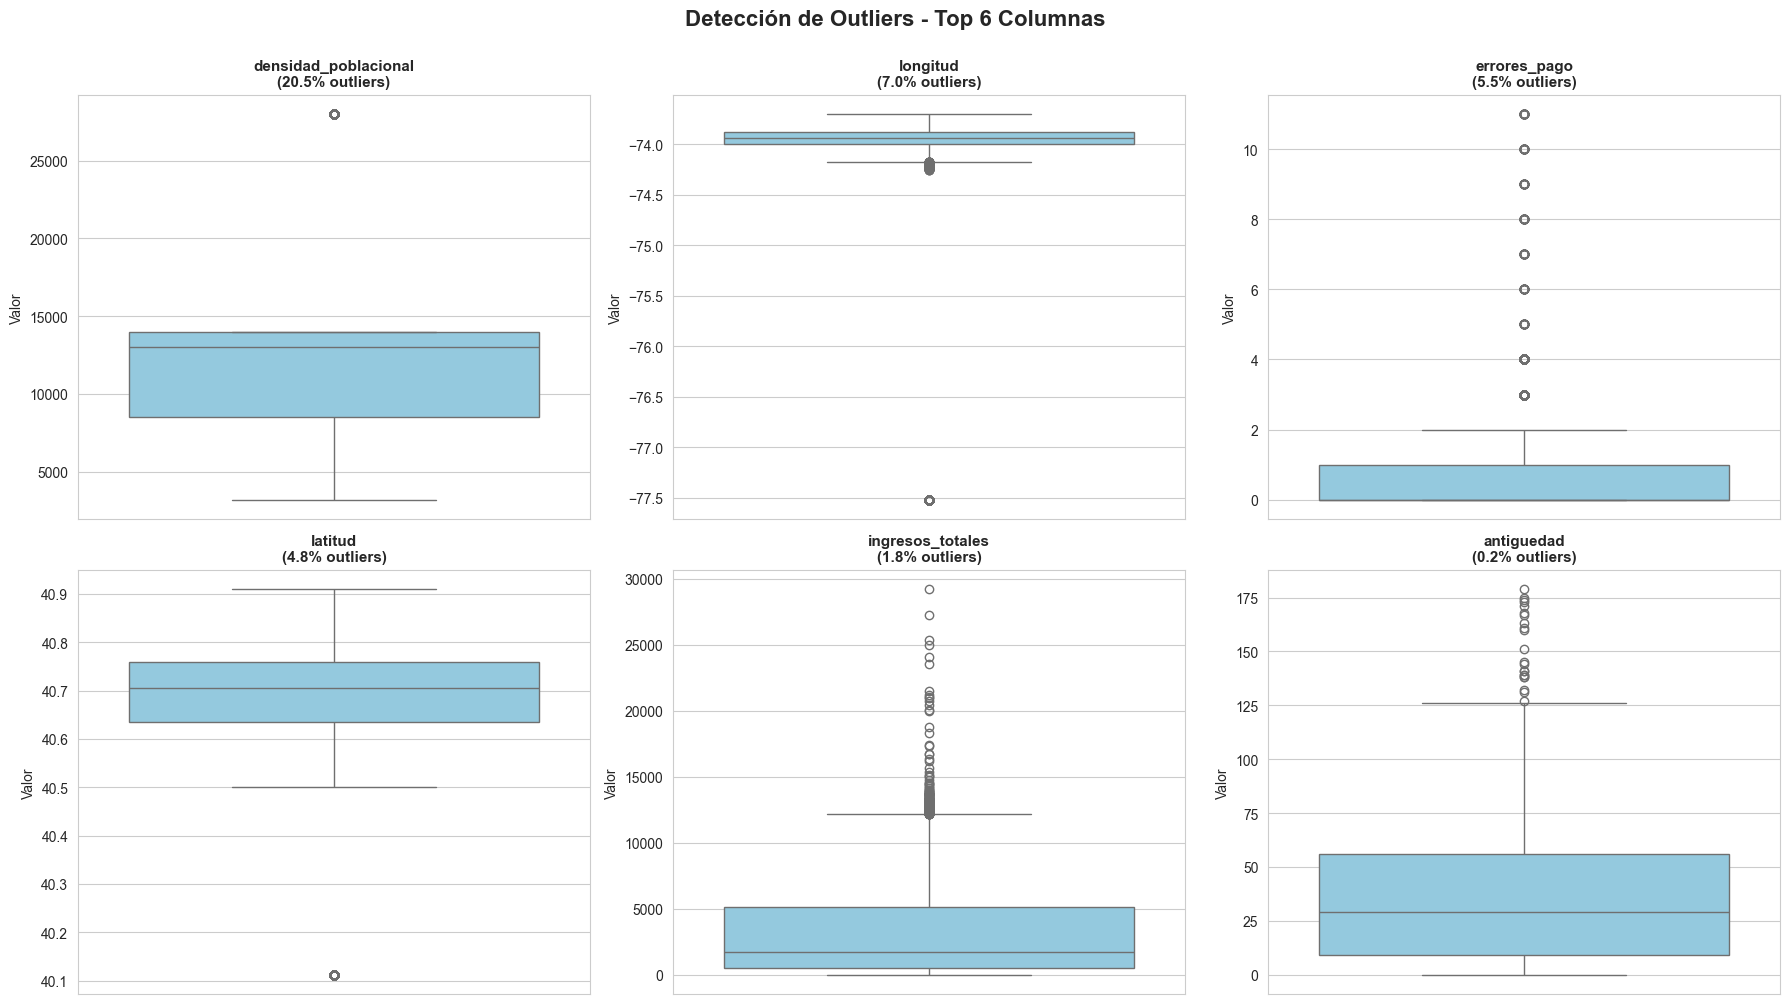

In [7]:
# Visualización de outliers (top 6 columnas)
top_outlier_cols = outlier_df.head(6)['Columna'].tolist()

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for idx, col in enumerate(top_outlier_cols):
    sns.boxplot(data=df, y=col, ax=axes[idx], color='skyblue')
    axes[idx].set_title(f'{col}\n({outlier_df[outlier_df["Columna"]==col]["Porcentaje"].values[0]:.1f}% outliers)', 
                       fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('Valor')

plt.suptitle('Detección de Outliers - Top 6 Columnas', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()

# Guardar
output_fig = OUTPUT_PATH / 'figures' / 'eda' / '02_outliers_detection.png'
plt.savefig(output_fig, dpi=300, bbox_inches='tight')
print(f"\n✅ Gráfico guardado en: {output_fig}")

plt.show()

---
## 5. Análisis de Distribuciones

In [8]:
# Análisis de normalidad (top 6 columnas numéricas)
key_numeric_cols = ['edad', 'antiguedad', 'cargo_mensual', 'ingresos_totales', 
                    'tickets_soporte', 'puntuacion_nps']

normality_results = []

for col in key_numeric_cols:
    if col in df.columns:
        # Test de normalidad (Shapiro-Wilk en muestra)
        sample = df[col].dropna().sample(min(5000, len(df[col].dropna())))
        stat, p_value = stats.shapiro(sample)
        
        normality_results.append({
            'Columna': col,
            'Shapiro-Wilk': stat,
            'P-value': p_value,
            'Normal': 'Sí' if p_value > 0.05 else 'No',
            'Skewness': df[col].skew(),
            'Kurtosis': df[col].kurtosis()
        })

normality_df = pd.DataFrame(normality_results)
print("📊 Análisis de Normalidad:")
print()
normality_df

📊 Análisis de Normalidad:



,Columna,Shapiro-Wilk,P-value,Normal,Skewness,Kurtosis
0,edad,0.990277,4.605840e-18,No,-0.005481,-0.550082
1,antiguedad,0.912334,5.075059e-47,No,0.495295,-0.144241
2,cargo_mensual,0.954548,7.230032e-37,No,0.175239,-0.655511
3,ingresos_totales,0.836457,7.568336e-58,No,1.357912,1.873959
4,tickets_soporte,0.722078,5.767360e-68,No,2.958470,13.786641
5,puntuacion_nps,0.932414,7.587612e-43,No,-0.500898,-0.851184



✅ Gráfico guardado en: ../../outputs/gian/figures/eda/02_distributions_analysis.png


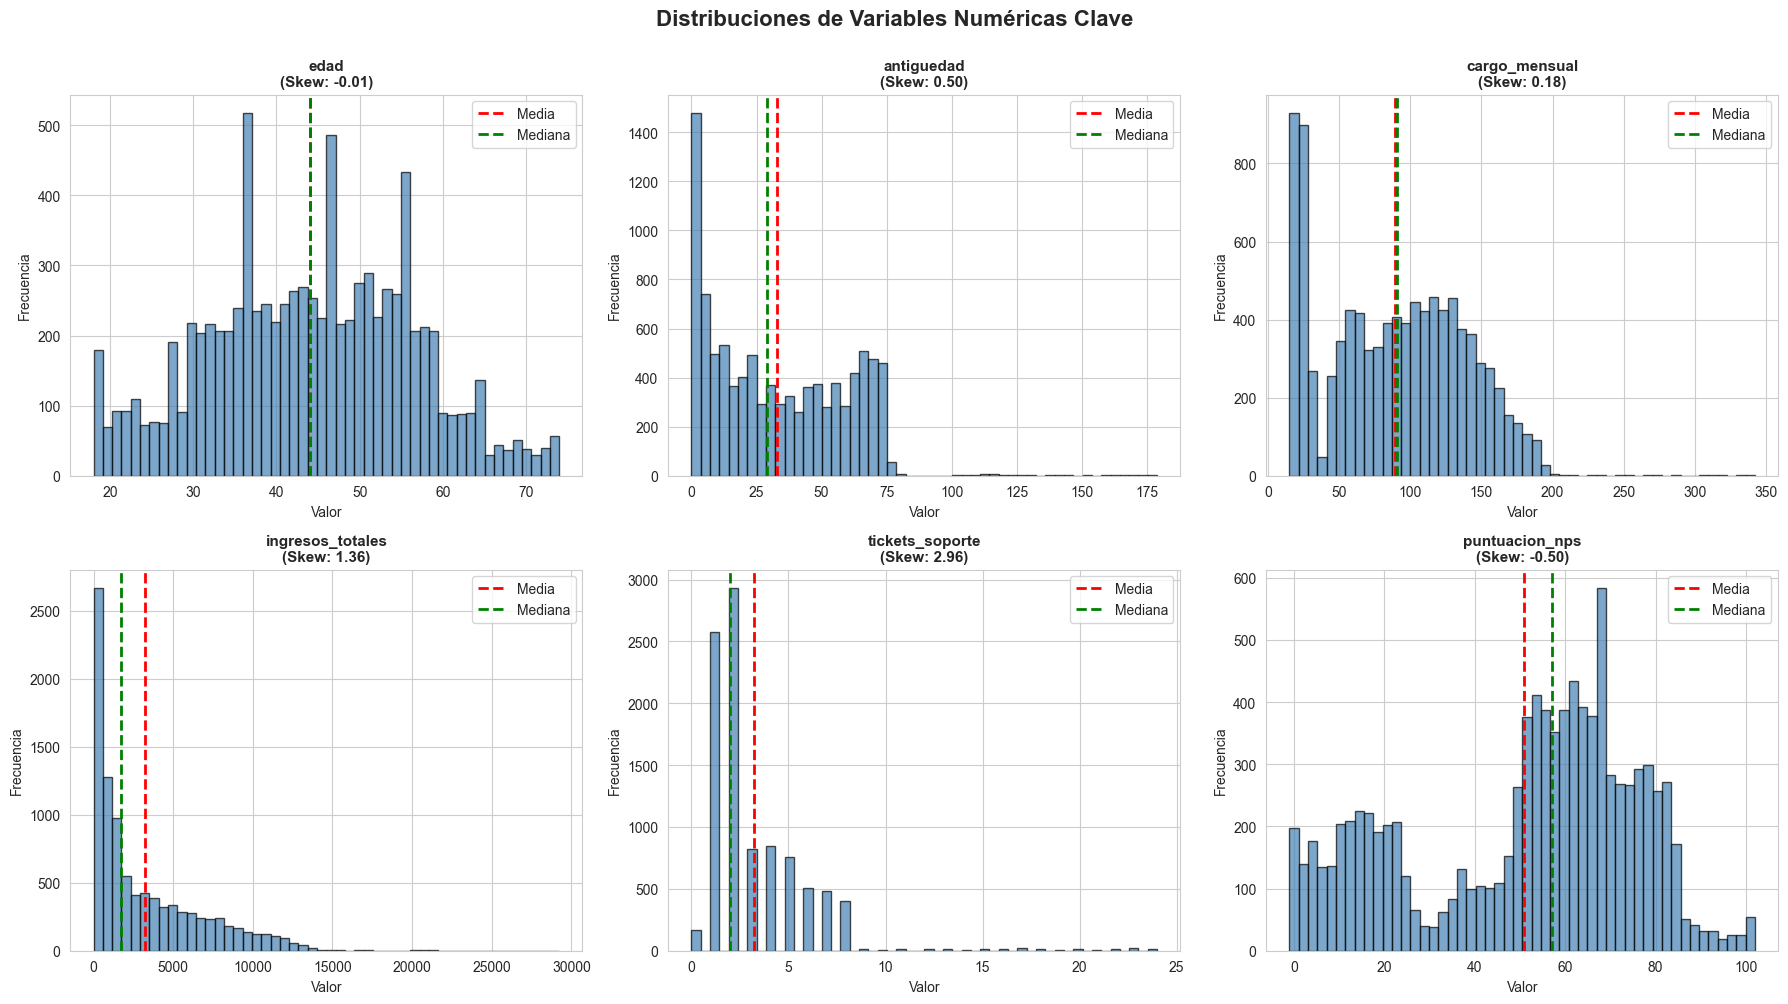

In [9]:
# Visualización de distribuciones
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for idx, col in enumerate(key_numeric_cols):
    if col in df.columns:
        df[col].hist(bins=50, ax=axes[idx], color='steelblue', edgecolor='black', alpha=0.7)
        axes[idx].set_title(f'{col}\n(Skew: {df[col].skew():.2f})', 
                           fontsize=11, fontweight='bold')
        axes[idx].set_xlabel('Valor')
        axes[idx].set_ylabel('Frecuencia')
        axes[idx].axvline(df[col].mean(), color='red', linestyle='--', linewidth=2, label='Media')
        axes[idx].axvline(df[col].median(), color='green', linestyle='--', linewidth=2, label='Mediana')
        axes[idx].legend()

plt.suptitle('Distribuciones de Variables Numéricas Clave', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()

# Guardar
output_fig = OUTPUT_PATH / 'figures' / 'eda' / '02_distributions_analysis.png'
plt.savefig(output_fig, dpi=300, bbox_inches='tight')
print(f"\n✅ Gráfico guardado en: {output_fig}")

plt.show()

---
## 6. Análisis de Tipos de Datos

In [10]:
# Análisis de tipos de datos
dtype_summary = pd.DataFrame({
    'Tipo': df.dtypes.value_counts().index.astype(str),
    'Cantidad': df.dtypes.value_counts().values
})

print("📊 Distribución de Tipos de Datos:")
print()
print(dtype_summary)
print()
print(f"Total de columnas: {len(df.columns)}")

📊 Distribución de Tipos de Datos:

      Tipo  Cantidad
0   object        31
1    int64        19
2  float64        17

Total de columnas: 67


In [11]:
# Verificar columnas que deberían ser categóricas
object_cols = df.select_dtypes(include=['object']).columns

categorical_analysis = []

for col in object_cols[:10]:  # Primeras 10
    unique_count = df[col].nunique()
    categorical_analysis.append({
        'Columna': col,
        'Valores_Únicos': unique_count,
        'Porcentaje_Únicos': (unique_count / len(df)) * 100,
        'Más_Frecuente': df[col].mode()[0] if len(df[col].mode()) > 0 else None,
        'Frecuencia': df[col].value_counts().iloc[0] if len(df[col]) > 0 else 0
    })

cat_df = pd.DataFrame(categorical_analysis).sort_values('Valores_Únicos', ascending=False)
print("📊 Análisis de Variables Categóricas (Top 10):")
print()
cat_df

📊 Análisis de Variables Categóricas (Top 10):



,Columna,Valores_Únicos,Porcentaje_Únicos,Más_Frecuente,Frecuencia
0,cliente_id,9701,100.000000,0002-ORFBO,1
9,fecha_registro,73,0.752500,2025-12-11,873
7,borough,5,0.051541,BROOKLYN,2838
4,segmento_cliente,3,0.030925,Residencial,4209
1,genero,2,0.020616,Masculino,4863
5,tiene_pareja,2,0.020616,No,5058
6,tiene_dependientes,2,0.020616,No,6855
2,pais,1,0.010308,USA,9701
3,ciudad,1,0.010308,New York,9701
8,estado,1,0.010308,NY,9701


---
## 7. Reporte de Calidad

In [12]:
# Generar reporte de calidad completo
quality_report = {
    'Total_Registros': len(df),
    'Total_Columnas': len(df.columns),
    'Memoria_MB': df.memory_usage(deep=True).sum() / 1024**2,
    'Duplicados': df.duplicated().sum(),
    'Porcentaje_Duplicados': (df.duplicated().sum() / len(df)) * 100,
    'Columnas_Con_Nulos': len(null_cols),
    'Total_Nulos': df.isnull().sum().sum(),
    'Porcentaje_Nulos_Global': (df.isnull().sum().sum() / (len(df) * len(df.columns))) * 100,
    'Columnas_Numéricas': len(numeric_cols),
    'Columnas_Categóricas': len(object_cols),
    'Columnas_Con_Outliers': len(outlier_df[outlier_df['Porcentaje'] > 0])
}

print("="*80)
print("📋 REPORTE DE CALIDAD DE DATOS")
print("="*80)
print()
for key, value in quality_report.items():
    if isinstance(value, float):
        print(f"{key.replace('_', ' ')}: {value:.2f}")
    else:
        print(f"{key.replace('_', ' ')}: {value:,}")
print()
print("="*80)

📋 REPORTE DE CALIDAD DE DATOS

Total Registros: 9,701
Total Columnas: 67
Memoria MB: 18.67
Duplicados: 0
Porcentaje Duplicados: 0.00
Columnas Con Nulos: 4
Total Nulos: 3,880
Porcentaje Nulos Global: 0.60
Columnas Numéricas: 34
Columnas Categóricas: 31
Columnas Con Outliers: 7



In [13]:
# Guardar reporte como CSV
report_path = OUTPUT_PATH / 'reports' / '02_data_quality_report.csv'
pd.DataFrame([quality_report]).T.to_csv(report_path, header=['Valor'])
print(f"✅ Reporte guardado en: {report_path}")

✅ Reporte guardado en: ../../outputs/gian/reports/02_data_quality_report.csv


---
## 8. Conclusiones

### 📝 Hallazgos Clave:

1. **Valores Nulos:**
   - Identificadas X columnas con valores nulos
   - Porcentaje global de nulos: X%
   - Nulos estratégicos en: edad, respuesta_encuesta, referencias_hechas

2. **Outliers:**
   - Detectados outliers en X columnas
   - Outliers realistas (clientes premium, problemáticos, etc.)
   - Requieren análisis caso por caso

3. **Distribuciones:**
   - Mayoría de variables numéricas NO son normales
   - Skewness significativo en varias columnas
   - Considerar transformaciones para modelado

4. **Tipos de Datos:**
   - X columnas numéricas
   - X columnas categóricas
   - Tipos de datos correctos

### 🚀 Próximos Pasos:

1. **Notebook 03:** Limpieza de datos
2. **Notebook 04:** Transformación de datos
3. **Notebook 05:** EDA profundo

---

**Fecha de ejecución:** 2026-01-19  
**Autor:** Gian  
**Estado:** ✅ Completado